<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/master/sample_size_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import joblib
import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

%tensorflow_version 2.x
import tensorflow as tf

# Load Data from Drive

In [0]:
obs = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/obs.pkl')
prefs = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/pref.pkl')
conv_acts = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/convAct.pkl')
dens_acts = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/densAct.pkl')

# Modelling Functions

1. Metrics
2. DNN
3. Training code

In [0]:
def get_val_auc(logs):
      for key in logs:
        if key.startswith('val_auc'):
          return logs[key]

class BestStats(tf.keras.callbacks.Callback):
  """A callback to keep track of the best val accuracy and auc seen so far."""
  def on_train_begin(self, logs):
      self.bestMetric = -float('inf')
      self.bestLogs = None
      self.bestTrain = -float('inf')
      self.num_epochs = 0

  def on_epoch_end(self, epoch, logs):
    self.num_epochs += 1
    self.bestTrain = max(self.bestTrain, logs.get('accuracy'))

    val_accuracy = logs.get('val_accuracy')
    if val_accuracy == None:
      return 

    val_auc = get_val_auc(logs)
    
    metric = (val_accuracy + val_auc) / 2.0

    if metric > self.bestMetric:
      self.bestMetric = metric
      self.bestLogs = logs

In [0]:
def dnn(reg_amount, drop_rate, layer_sizes):

  layers = []
  for layer_size in layer_sizes:
    layers.append(tf.keras.layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_amount)))
    layers.append(tf.keras.layers.Dropout(drop_rate))

  model = tf.keras.models.Sequential(layers + [
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_amount))
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(.01),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC()],
                )
  return model

In [0]:
def train_best_logs(xs, ys, num_train, num_val, do_summary, hparams, model, epochs):
  """Trains the model and retruns the logs of the best epoch. randomly splits the train and val data before training."""
  tf.keras.backend.clear_session()
  model = model(**hparams)
  xs, ys = shuffle(xs, ys)

  xs_val = xs[num_train:num_train+num_val]
  ys_val = ys[num_train:num_train+num_val]
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0)
  best_stats = BestStats()
  model.fit(xs[:num_train], ys[:num_train], epochs=epochs, batch_size=256, validation_freq=1, callbacks=[best_stats, early_stopping], validation_data=(xs_val, ys_val), verbose=0)

  if do_summary:
    model.summary()
    print("Best train accuracy:", best_stats.bestTrain)
    print("Number of epochs:", best_stats.num_epochs)
    
  return best_stats.bestLogs

def multiple_train_ave(hparams, model, xs_for_train, ys, num_train, num_val, epochs, num_repeat = 5):
  """Trains the model multiple times with the same parameters and returns the average metrics"""
  start = time.time()
  all_val_auc = []
  all_val_accuracy = []

  do_summary = True
  for i in range(num_repeat):
    print('Doing training iteration no.', i+1)
    logs = train_best_logs(xs_for_train, ys, num_train, num_val, do_summary, hparams, model, epochs)
    all_val_auc.append(get_val_auc(logs))
    all_val_accuracy.append(logs.get('val_accuracy'))
    do_summary = False 

  mean_val_auc = np.mean(all_val_auc)
  mean_val_accuracy = np.mean(all_val_accuracy)
  metric = (mean_val_auc + mean_val_accuracy) / 2.0
  print_data = ("mean_val_auc", mean_val_auc, "mean_val_accuracy", mean_val_accuracy, "metric", metric, "val_auc_std", np.std(all_val_auc), "val_accuracy_std", np.std(all_val_accuracy))

  end = time.time()

  return metric, print_data

def train_eval(hparams, model, xs, ys, num_train, num_val, epochs):
    
    print("Model:", model)
    print("Shape of input:", xs.shape)
    print("Hyperparameters:", hparams)
    print("Number of training data:", num_train)
    print("Number of validation data:", num_val)
    print("Number of epochs:", epochs)
    
    metric, print_data = multiple_train_ave(hparams, model, xs, ys, num_train, num_val, epochs)
    print("Results", print_data)

    return print_data

# Sample Size Experiment

In [0]:
ys = (prefs > -6).astype(int)

In [22]:
tr_num = [50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000]
scores = []
for tr in tr_num:

    res = train_eval({'drop_rate': 0, 'layer_sizes': (32,), 'reg_amount': 0}, 
                     dnn, dens_acts, ys, num_train=tr, num_val=2000, epochs=400)
    scores.append(res[1])

Model: <function dnn at 0x7f01f10fdf28>
Shape of input: (23750, 64)
Hyperparameters: {'drop_rate': 0, 'layer_sizes': (32,), 'reg_amount': 0}
Number of training data: 50
Number of validation data: 2000
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2080      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  33        
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
_________________________________________________________________
Best train accuracy: 1.0
Number of epochs: 79
Doing training iteration no. 2
Doing training iteration no. 3
Doing training iterati

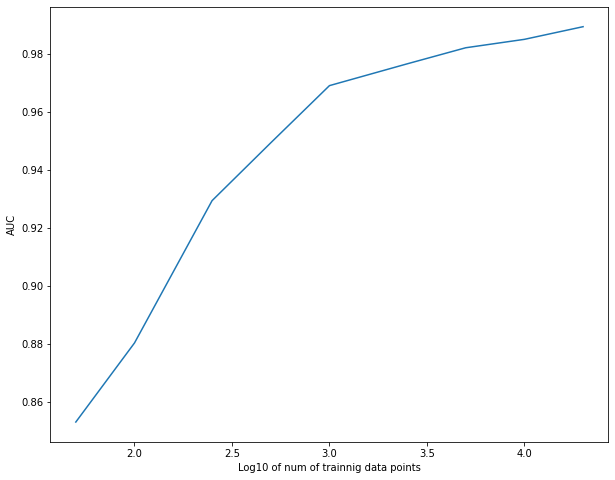

In [8]:
tr_num = [50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000]
scores = [0.8530540704727173, 0.8802994370460511, 0.9293254971504211, 0.9492498517036438, 
          0.9689507603645324, 0.9764461040496826, 0.9819957137107849, 0.9848965525627136, 0.9892564296722413]

plt.figure(figsize=(10,8))
plt.plot(np.log10(tr_num), scores)

plt.ylabel("AUC")
plt.xlabel("Log10 of num of trainnig data points")
plt.show()